# Example 4: Classification

## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 2, CrossEntropy loss). 

Create the two moon datatset

In [1]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()


In [2]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args_dict = {
    'grid': 5,
    #'grid': 10,
    'k': 3,
    'seed': 2024,
    'base_fun': "zero",
    'sp_trainable': False,
    'sb_trainable': False,
    'affine_trainable': False,
    'update_grid': False,
    #'base_fun': ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs'],
    #'spline_noise_scale': 0.1,
    'mode': 'default',
    #'init_mode': 'default',
    'init_mode': 'kaiming_in',
    'moon_noise': 0.0,
    'bounds': (-1,1)
}
args = Args(**args_dict)


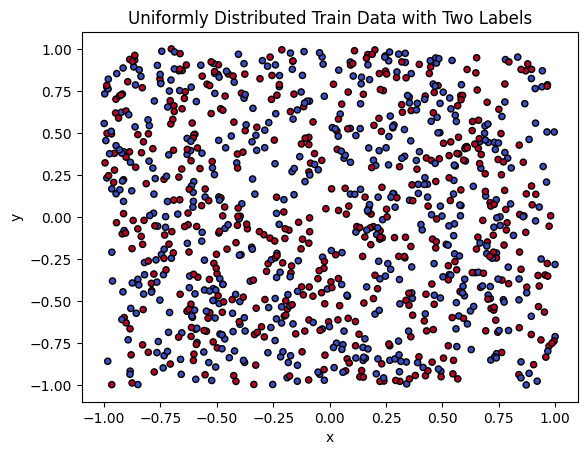

In [3]:
# Create uniformly distributed train and test datasets with two labels
rng = np.random.RandomState() #args.seed)

n_samples = 1000
#bounds = args.bounds if 'args' in locals() else (-1, 1)
bounds = (-1, 1)

# Train data
train_input = rng.uniform(low=bounds[0], high=bounds[1], size=(n_samples, 2))
train_label = rng.randint(0, 2, size=n_samples)

# Test data
test_input = rng.uniform(low=bounds[0], high=bounds[1], size=(n_samples, 2))
test_label = rng.randint(0, 2, size=n_samples)

dataset = {}
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']

# Optionally plot the train data
plt.scatter(train_input[:, 0], train_input[:, 1], c=train_label, cmap='coolwarm', edgecolor='k', s=20)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Uniformly Distributed Train Data with Two Labels')
plt.show()

### Train KAN

In [4]:
# Plot decision boundaries for each layer individually
import matplotlib.pyplot as plt

# Helper to get activations from each layer
def get_layer_activations(model, x):
    acts = []
    out = x
    for layer in model.act_fun:
        out, *_ = layer(out)
        acts.append(out)

    return acts


In [5]:
from scipy.ndimage import label

def count_islands_per_layer(layer_acts, xx):
    islands_per_layer = []
    for act in layer_acts:
        preds = torch.argmax(act, dim=1).cpu().numpy()
        mask = preds.reshape(xx.shape)
        # Label connected regions for each class and sum
        total_islands = 0
        for class_val in np.unique(mask):
            structure = np.ones((3, 3), dtype=int)
            labeled, num = label(mask == class_val, structure=structure)
            total_islands += num
        islands_per_layer.append(total_islands)
    return islands_per_layer


In [6]:
width_networks = [
    [2,3,3,2], 
    [2,4,4,2], 
    [2,5,5,2],
    [2,6,6,2],
    [2,7,7,2],
    [2,3,3,2], 
    [2,4,4,2], 
    [2,5,5,2],
    [2,6,6,2],
    [2,7,7,2],
    [2,3,3,2], 
    [2,4,4,2], 
    [2,5,5,2],
    [2,6,6,2],
    [2,7,7,2]
]

depth_networks = [
    [2,2,2,2,2],
    [2,2,2,2,2,2], 
    [2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2,2],
    [2,2,2,2,2],
    [2,2,2,2,2,2], 
    [2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2,2],
    [2,2,2,2,2],
    [2,2,2,2,2,2], 
    [2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2,2]
]

for w in width_networks:
    print(w)

[2, 3, 3, 2]
[2, 4, 4, 2]
[2, 5, 5, 2]
[2, 6, 6, 2]
[2, 7, 7, 2]
[2, 3, 3, 2]
[2, 4, 4, 2]
[2, 5, 5, 2]
[2, 6, 6, 2]
[2, 7, 7, 2]
[2, 3, 3, 2]
[2, 4, 4, 2]
[2, 5, 5, 2]
[2, 6, 6, 2]
[2, 7, 7, 2]


In [7]:
# Count islands per layer for all width and depth networks
import gc
from copy import deepcopy 

def get_islands_per_layer_for_widths(width_list, args):
    results = []
    for width in width_list:

        # Initialize and train model
        model = KAN(
            width=deepcopy(width),
            device=device,
            grid=args.grid, k=args.k, 
            #seed=args.seed,
            base_fun=args.base_fun,
            mode=args.mode,
            init_mode=args.init_mode,
        )

        def train_acc():
            return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

        def test_acc():
            return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

        model_res = model.fit(
            dataset, 
            opt="LBFGS", 
            steps=20, 
            #metrics=None, 
            metrics=(train_acc, test_acc), 
            loss_fn=torch.nn.CrossEntropyLoss(),
            update_grid=args.update_grid
        )

        xx, yy = torch.meshgrid(
            torch.linspace(*args.bounds, 2000, device=device),
            torch.linspace(*args.bounds, 2000, device=device),
            indexing='ij'
        )
        grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).type(dtype).to(device)

        # Get activations
        with torch.no_grad():
            layer_acts = get_layer_activations(model, grid)
        # Count islands
        islands = count_islands_per_layer(layer_acts, xx)

        results.append({'width': width, 'islands': islands, 'splines_num': sum(width), 'train_acc': model_res['train_acc'], 'test_acc': model_res['test_acc']}) #, 'layer_acts': layer_acts, 'model': model, 'args': args})
        with torch.no_grad():
            gc.collect()
            del model, xx, yy, grid
            torch.cuda.empty_cache()
    return results

width_islands = get_islands_per_layer_for_widths(width_networks, args)
depth_islands = get_islands_per_layer_for_widths(depth_networks, args)


checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 7.23e-01 | test_loss: 9.67e-01 | reg: 2.69e+01 | : 100%|█| 20/20 [00:12<00:00,  1.61it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.81e-01 | test_loss: 1.07e+00 | reg: 3.85e+01 | : 100%|█| 20/20 [00:08<00:00,  2.26it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.13e-01 | test_loss: 1.21e+00 | reg: 5.07e+01 | : 100%|█| 20/20 [00:08<00:00,  2.24it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.47e-01 | test_loss: 1.38e+00 | reg: 6.03e+01 | : 100%|█| 20/20 [00:08<00:00,  2.28it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.54e-01 | test_loss: 1.87e+00 | reg: 7.86e+01 | : 100%|█| 20/20 [00:08<00:00,  2.29it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.24e-01 | test_loss: 9.68e-01 | reg: 2.67e+01 | : 100%|█| 20/20 [00:08<00:00,  2.23it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.88e-01 | test_loss: 1.06e+00 | reg: 3.77e+01 | : 100%|█| 20/20 [00:08<00:00,  2.30it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.85e-01 | test_loss: 1.29e+00 | reg: 5.12e+01 | : 100%|█| 20/20 [00:08<00:00,  2.25it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.44e-01 | test_loss: 1.39e+00 | reg: 6.04e+01 | : 100%|█| 20/20 [00:10<00:00,  1.99it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.48e-01 | test_loss: 1.92e+00 | reg: 8.11e+01 | : 100%|█| 20/20 [00:10<00:00,  1.90it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.22e-01 | test_loss: 9.61e-01 | reg: 2.67e+01 | : 100%|█| 20/20 [00:08<00:00,  2.24it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.85e-01 | test_loss: 1.05e+00 | reg: 3.80e+01 | : 100%|█| 20/20 [00:09<00:00,  2.21it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.03e-01 | test_loss: 1.25e+00 | reg: 4.96e+01 | : 100%|█| 20/20 [00:09<00:00,  2.16it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.47e-01 | test_loss: 1.39e+00 | reg: 6.07e+01 | : 100%|█| 20/20 [00:09<00:00,  2.21it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.63e-01 | test_loss: 1.88e+00 | reg: 7.74e+01 | : 100%|█| 20/20 [00:08<00:00,  2.27it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.80e-01 | test_loss: 9.12e-01 | reg: 2.78e+01 | : 100%|█| 20/20 [00:11<00:00,  1.68it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.68e-01 | test_loss: 9.29e-01 | reg: 3.34e+01 | : 100%|█| 20/20 [00:14<00:00,  1.38it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.61e-01 | test_loss: 9.15e-01 | reg: 3.75e+01 | : 100%|█| 20/20 [00:17<00:00,  1.14it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.63e-01 | test_loss: 9.03e-01 | reg: 4.61e+01 | : 100%|█| 20/20 [00:20<00:00,  1.02s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.70e-01 | test_loss: 8.88e-01 | reg: 5.10e+01 | : 100%|█| 20/20 [00:22<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.79e-01 | test_loss: 9.15e-01 | reg: 2.81e+01 | : 100%|█| 20/20 [00:11<00:00,  1.69it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.66e-01 | test_loss: 9.20e-01 | reg: 3.38e+01 | : 100%|█| 20/20 [00:14<00:00,  1.36it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.56e-01 | test_loss: 9.28e-01 | reg: 3.76e+01 | : 100%|█| 20/20 [00:17<00:00,  1.13it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.67e-01 | test_loss: 8.83e-01 | reg: 4.55e+01 | : 100%|█| 20/20 [00:20<00:00,  1.02s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.51e-01 | test_loss: 8.78e-01 | reg: 5.12e+01 | : 100%|█| 20/20 [00:23<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.75e-01 | test_loss: 9.14e-01 | reg: 2.78e+01 | : 100%|█| 20/20 [00:11<00:00,  1.67it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.68e-01 | test_loss: 9.07e-01 | reg: 3.22e+01 | : 100%|█| 20/20 [00:14<00:00,  1.38it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.63e-01 | test_loss: 9.19e-01 | reg: 3.82e+01 | : 100%|█| 20/20 [00:17<00:00,  1.13it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.73e-01 | test_loss: 8.83e-01 | reg: 4.56e+01 | : 100%|█| 20/20 [00:20<00:00,  1.02s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.06e-01 | test_loss: 8.50e-01 | reg: 5.23e+01 | : 100%|█| 20/20 [00:25<00:00,  1.26s/


saving model version 0.1


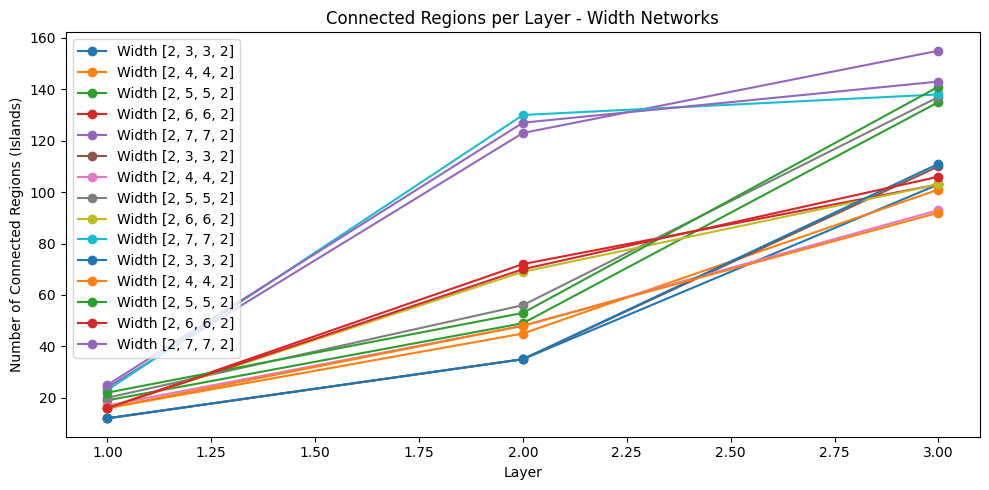

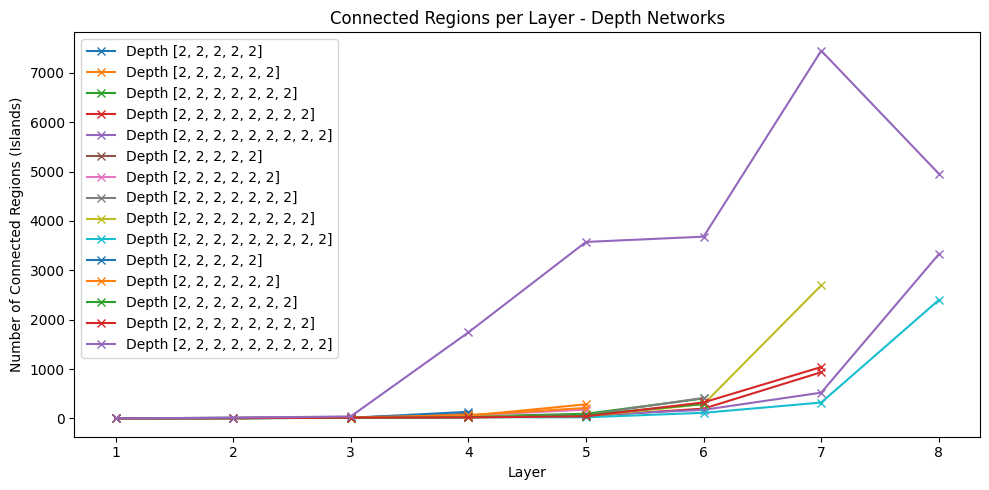

In [8]:
import matplotlib.pyplot as plt

# Plot islands per layer for width networks
plt.figure(figsize=(10, 5))
for res in width_islands:
    plt.plot(range(1, len(res['islands']) + 1), res['islands'], marker='o', label=f'Width {res["width"]}')
plt.xlabel('Layer')
plt.ylabel('Number of Connected Regions (Islands)')
plt.title('Connected Regions per Layer - Width Networks')
plt.legend()
plt.tight_layout()
plt.show()

# Plot islands per layer for depth networks
plt.figure(figsize=(10, 5))
for res in depth_islands:
    plt.plot(range(1, len(res['islands']) + 1), res['islands'], marker='x', label=f'Depth {res["width"]}')
plt.xlabel('Layer')
plt.ylabel('Number of Connected Regions (Islands)')
plt.title('Connected Regions per Layer - Depth Networks')
plt.legend()
plt.tight_layout()
plt.show()

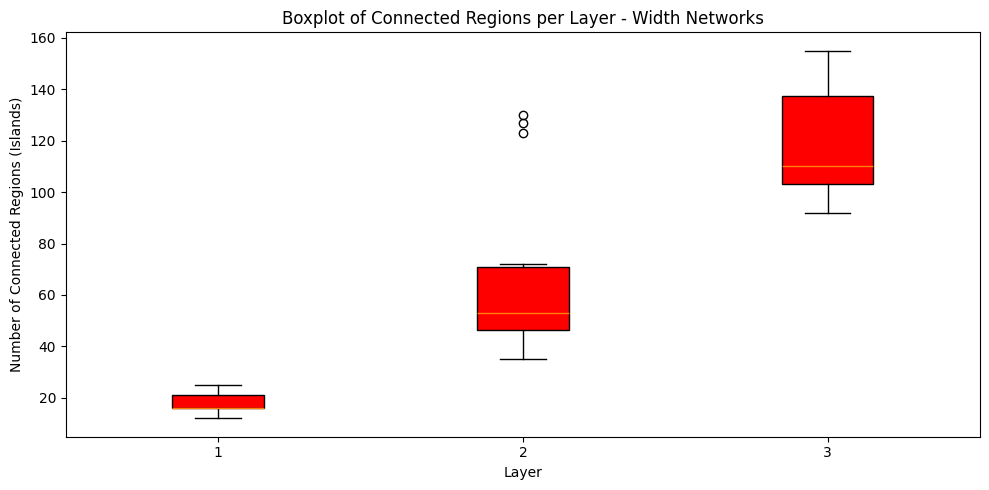

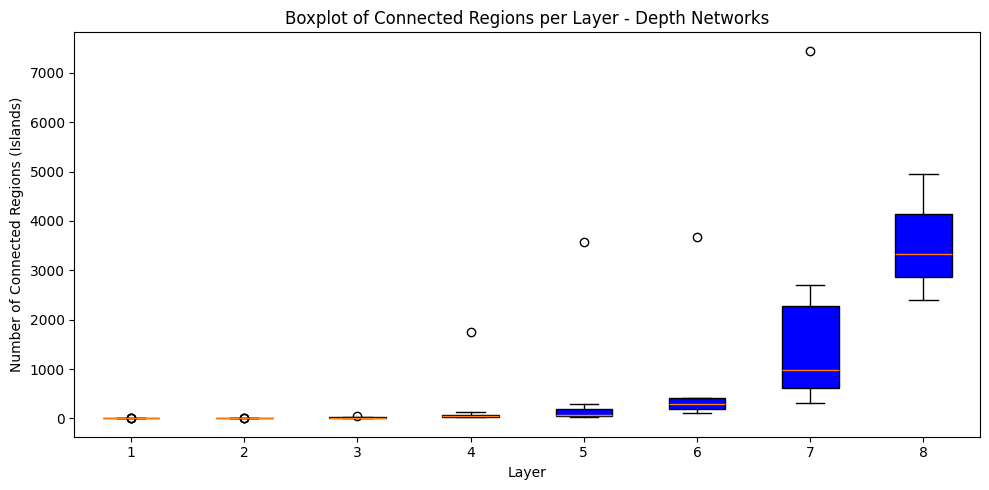

In [9]:
import matplotlib.pyplot as plt

# Boxplot for width networks
plt.figure(figsize=(10, 5))
# Collect islands per layer for each width network
max_layers_width = max(len(res['islands']) for res in width_islands)
islands_per_layer_width = [[] for _ in range(max_layers_width)]
for res in width_islands:
    for i, val in enumerate(res['islands']):
        islands_per_layer_width[i].append(val)
plt.boxplot(islands_per_layer_width, positions=range(1, max_layers_width + 1), patch_artist=True, boxprops=dict(facecolor="red"))
plt.xlabel('Layer')
plt.ylabel('Number of Connected Regions (Islands)')
plt.title('Boxplot of Connected Regions per Layer - Width Networks')
plt.xticks(range(1, max_layers_width + 1))
plt.tight_layout()
plt.show()

# Boxplot for depth networks
plt.figure(figsize=(10, 5))
max_layers_depth = max(len(res['islands']) for res in depth_islands)
islands_per_layer_depth = [[] for _ in range(max_layers_depth)]
for res in depth_islands:
    for i, val in enumerate(res['islands']):
        islands_per_layer_depth[i].append(val)
plt.boxplot(islands_per_layer_depth, positions=range(1, max_layers_depth + 1), patch_artist=True, boxprops=dict(facecolor="blue"))
plt.xlabel('Layer')
plt.ylabel('Number of Connected Regions (Islands)')
plt.title('Boxplot of Connected Regions per Layer - Depth Networks')
plt.xticks(range(1, max_layers_depth + 1))
plt.tight_layout()
plt.show()

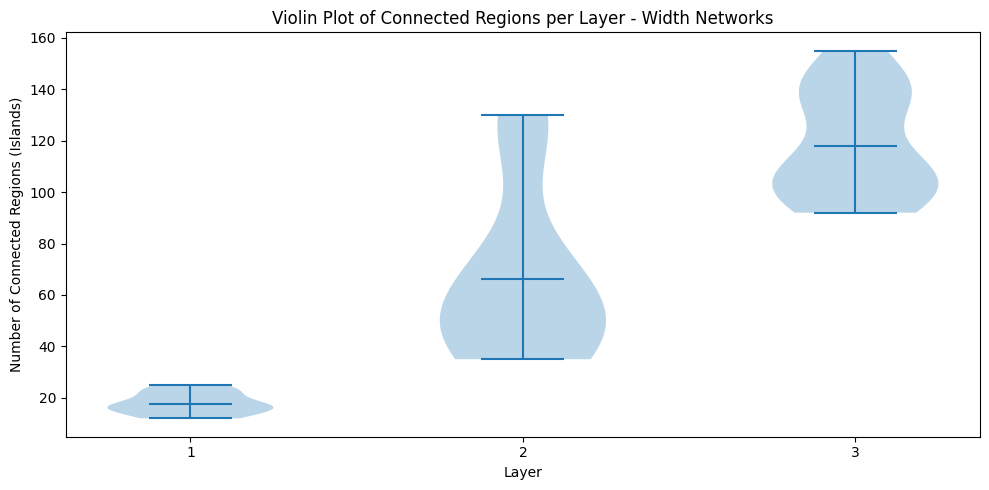

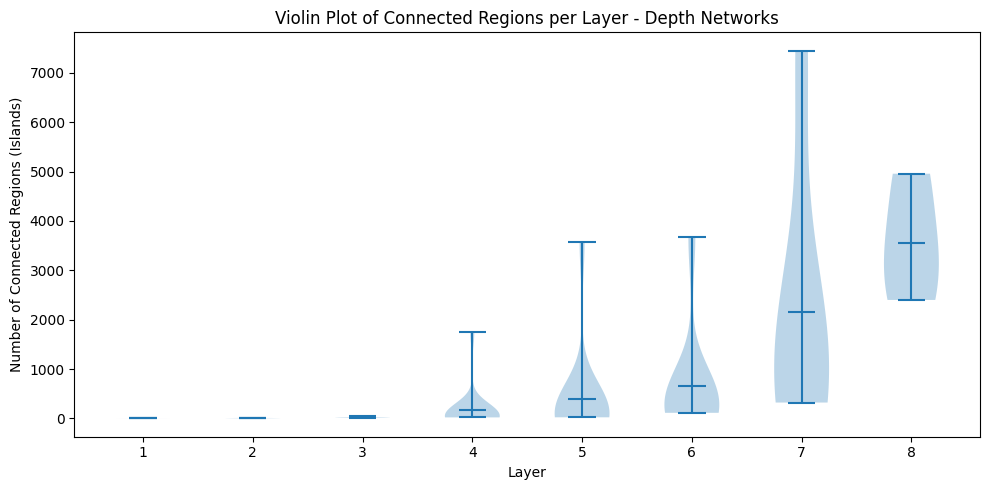

In [10]:
import matplotlib.pyplot as plt

# Violin plot for width networks
plt.figure(figsize=(10, 5))
max_layers_width = max(len(res['islands']) for res in width_islands)
islands_per_layer_width = [[] for _ in range(max_layers_width)]
for res in width_islands:
    for i, val in enumerate(res['islands']):
        islands_per_layer_width[i].append(val)
plt.violinplot(islands_per_layer_width, positions=range(1, max_layers_width + 1), showmeans=True)
plt.xlabel('Layer')
plt.ylabel('Number of Connected Regions (Islands)')
plt.title('Violin Plot of Connected Regions per Layer - Width Networks')
plt.xticks(range(1, max_layers_width + 1))
plt.tight_layout()
plt.show()

# Violin plot for depth networks
plt.figure(figsize=(10, 5))
max_layers_depth = max(len(res['islands']) for res in depth_islands)
islands_per_layer_depth = [[] for _ in range(max_layers_depth)]
for res in depth_islands:
    for i, val in enumerate(res['islands']):
        islands_per_layer_depth[i].append(val)
plt.violinplot(islands_per_layer_depth, positions=range(1, max_layers_depth + 1), showmeans=True)
plt.xlabel('Layer')
plt.ylabel('Number of Connected Regions (Islands)')
plt.title('Violin Plot of Connected Regions per Layer - Depth Networks')
plt.xticks(range(1, max_layers_depth + 1))
plt.tight_layout()
plt.show()

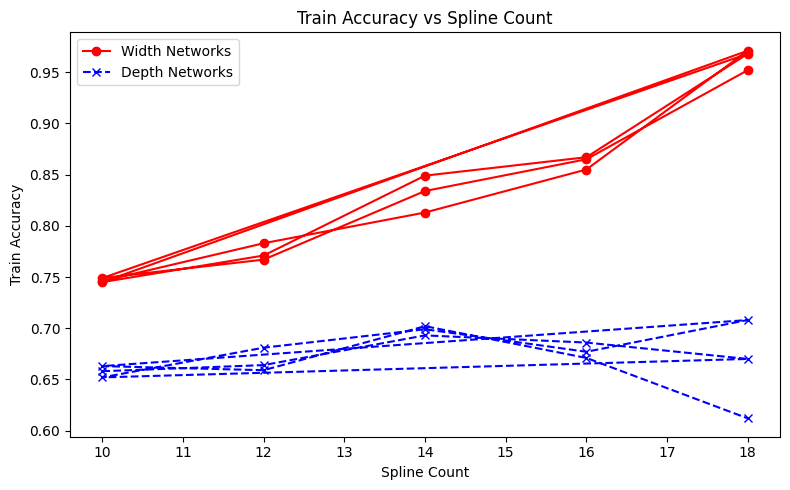

In [15]:
import matplotlib.pyplot as plt

# Extract spline counts and final train accuracies for width and depth networks
width_splines = [res['splines_num'] for res in width_islands]
width_train_acc = [res['train_acc'][-1] for res in width_islands]

depth_splines = [res['splines_num'] for res in depth_islands]
depth_train_acc = [res['train_acc'][-1] for res in depth_islands]

plt.figure(figsize=(8, 5))
plt.plot(width_splines, width_train_acc, 'o-', color='red', label='Width Networks')
plt.plot(depth_splines, depth_train_acc, 'x--', color='blue', label='Depth Networks')
plt.xlabel('Spline Count')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Spline Count')
plt.legend()
plt.tight_layout()
plt.show()

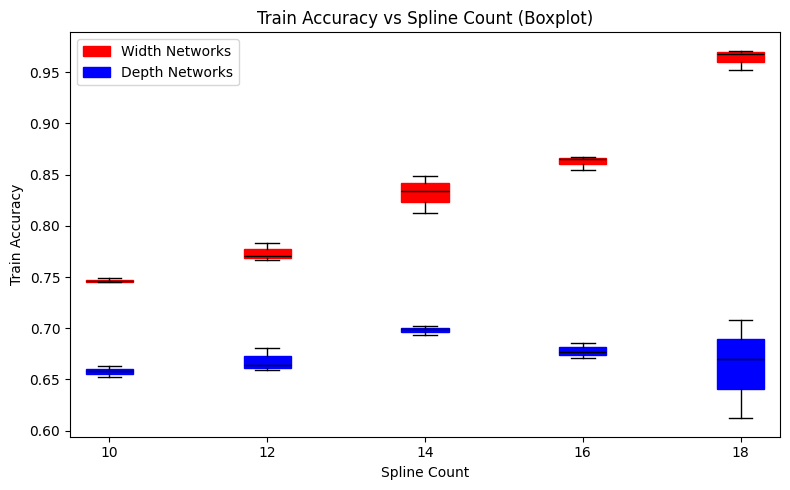

In [12]:
from collections import defaultdict

import matplotlib.pyplot as plt

# Prepare data for boxplot
width_splines = [res['splines_num'] for res in width_islands]
width_train_acc = [res['train_acc'][-1] for res in width_islands]

depth_splines = [res['splines_num'] for res in depth_islands]
depth_train_acc = [res['train_acc'][-1] for res in depth_islands]

# Group train accuracies by spline count for width and depth

width_acc_by_splines = defaultdict(list)
for res in width_islands:
    width_acc_by_splines[res['splines_num']].append(res['train_acc'][-1])

depth_acc_by_splines = defaultdict(list)
for res in depth_islands:
    depth_acc_by_splines[res['splines_num']].append(res['train_acc'][-1])

# Sort spline counts
width_splines_sorted = sorted(width_acc_by_splines.keys())
depth_splines_sorted = sorted(depth_acc_by_splines.keys())

# Prepare data for boxplot
width_data = [width_acc_by_splines[s] for s in width_splines_sorted]
depth_data = [depth_acc_by_splines[s] for s in depth_splines_sorted]

plt.figure(figsize=(8, 5))
box1 = plt.boxplot(width_data, positions=width_splines_sorted, widths=0.6, patch_artist=True, boxprops=dict(facecolor="red", color="red"), medianprops=dict(color="black"))
box2 = plt.boxplot(depth_data, positions=depth_splines_sorted, widths=0.6, patch_artist=True, boxprops=dict(facecolor="blue", color="blue"), medianprops=dict(color="black"))

plt.xlabel('Spline Count')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Spline Count (Boxplot)')
plt.xticks(sorted(set(width_splines + depth_splines)))
plt.legend([box1["boxes"][0], box2["boxes"][0]], ['Width Networks', 'Depth Networks'])
plt.tight_layout()
plt.show()

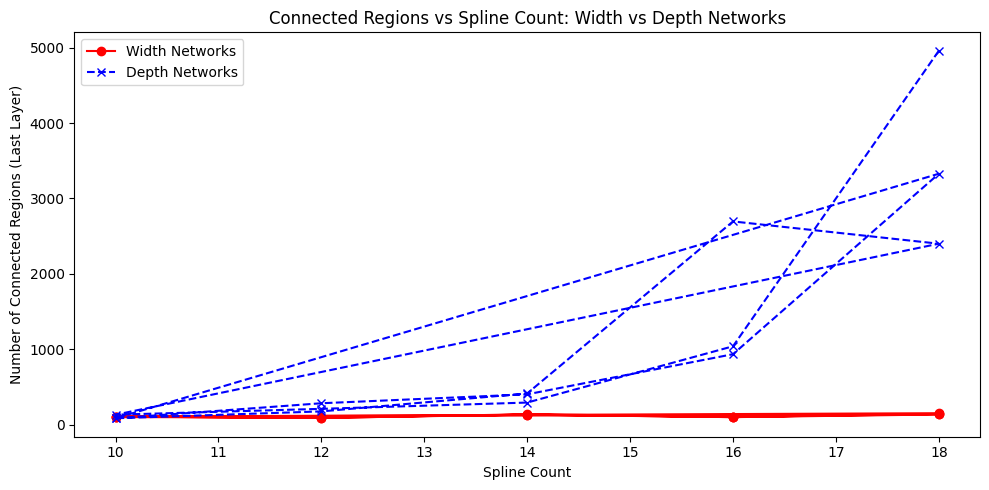

In [13]:
import matplotlib.pyplot as plt

# Prepare data for plotting
width_splines = [res['splines_num'] for res in width_islands]
width_last_islands = [res['islands'][-1] for res in width_islands]

depth_splines = [res['splines_num'] for res in depth_islands]
depth_last_islands = [res['islands'][-1] for res in depth_islands]

plt.figure(figsize=(10, 5))
plt.plot(width_splines, width_last_islands, 'o-', label='Width Networks', color='red')
plt.plot(depth_splines, depth_last_islands, 'x--', label='Depth Networks', color='blue')
plt.xlabel('Spline Count')
plt.ylabel('Number of Connected Regions (Last Layer)')
plt.title('Connected Regions vs Spline Count: Width vs Depth Networks')
plt.legend()
plt.tight_layout()
plt.show()

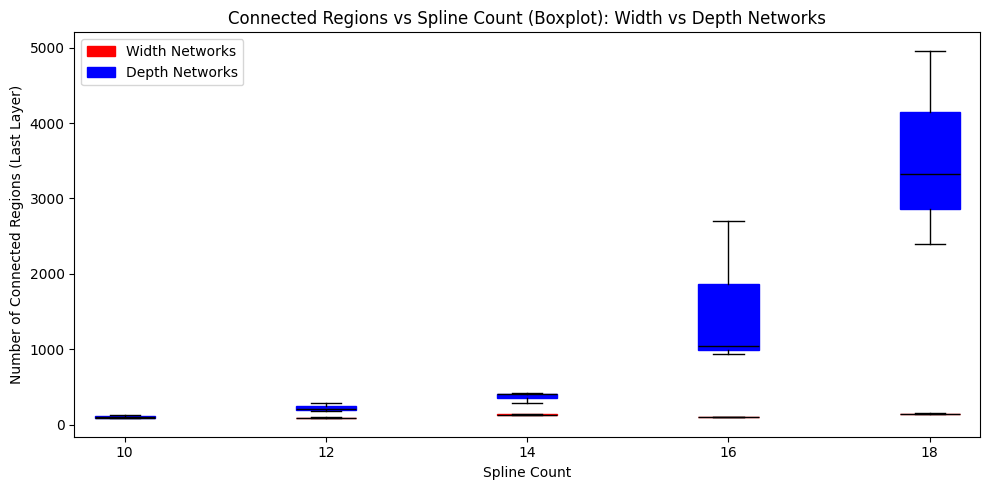

In [16]:
from collections import defaultdict

import matplotlib.pyplot as plt

# Prepare data for boxplot: group last layer islands by spline count for width and depth networks

width_islands_by_splines = defaultdict(list)
for res in width_islands:
    width_islands_by_splines[res['splines_num']].append(res['islands'][-1])

depth_islands_by_splines = defaultdict(list)
for res in depth_islands:
    depth_islands_by_splines[res['splines_num']].append(res['islands'][-1])

width_splines_sorted = sorted(width_islands_by_splines.keys())
depth_splines_sorted = sorted(depth_islands_by_splines.keys())

width_islands_data = [width_islands_by_splines[s] for s in width_splines_sorted]
depth_islands_data = [depth_islands_by_splines[s] for s in depth_splines_sorted]

plt.figure(figsize=(10, 5))
box1 = plt.boxplot(width_islands_data, positions=width_splines_sorted, widths=0.6, patch_artist=True, boxprops=dict(facecolor="red", color="red"), medianprops=dict(color="black"))
box2 = plt.boxplot(depth_islands_data, positions=depth_splines_sorted, widths=0.6, patch_artist=True, boxprops=dict(facecolor="blue", color="blue"), medianprops=dict(color="black"))

plt.xlabel('Spline Count')
plt.ylabel('Number of Connected Regions (Last Layer)')
plt.title('Connected Regions vs Spline Count (Boxplot): Width vs Depth Networks')
plt.xticks(sorted(set(width_splines_sorted + depth_splines_sorted)))
plt.legend([box1["boxes"][0], box2["boxes"][0]], ['Width Networks', 'Depth Networks'])
plt.tight_layout()
plt.show()

In [14]:
# Print results
for net_type, results in zip(['Width Networks', 'Depth Networks'], [width_islands, depth_islands]):
    print(f"\n{net_type}:")
    for res in results:
        print(f"Width: {res['width']}, Islands per layer: {res['islands']}, spline count: {res['splines_num']}")
        


Width Networks:
Width: [2, 3, 3, 2], Islands per layer: [12, 35, 103], spline count: 10
Width: [2, 4, 4, 2], Islands per layer: [16, 45, 101], spline count: 12
Width: [2, 5, 5, 2], Islands per layer: [19, 49, 135], spline count: 14
Width: [2, 6, 6, 2], Islands per layer: [16, 72, 103], spline count: 16
Width: [2, 7, 7, 2], Islands per layer: [24, 123, 155], spline count: 18
Width: [2, 3, 3, 2], Islands per layer: [12, 35, 110], spline count: 10
Width: [2, 4, 4, 2], Islands per layer: [17, 48, 93], spline count: 12
Width: [2, 5, 5, 2], Islands per layer: [20, 56, 137], spline count: 14
Width: [2, 6, 6, 2], Islands per layer: [16, 69, 103], spline count: 16
Width: [2, 7, 7, 2], Islands per layer: [23, 130, 138], spline count: 18
Width: [2, 3, 3, 2], Islands per layer: [12, 35, 111], spline count: 10
Width: [2, 4, 4, 2], Islands per layer: [16, 48, 92], spline count: 12
Width: [2, 5, 5, 2], Islands per layer: [22, 53, 141], spline count: 14
Width: [2, 6, 6, 2], Islands per layer: [16, 70